<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 7 October 2019, with material from Thomas Wiecki</div>

# Metropolis Lab 1

In class, many of you said you wanted to write your own [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), so here's the lab! We worked with estimating the **mean** of a model in our first notebook, so let's estimate **standard deviation** in this notebook.

This lab is to be done in class, in teams of 2. TAs will go around with the solution. You can ask for help at any step. TAs won't give you the solution, but they will help you find it. Answer all 10 questions in the notwbook (`a` to `i`), and post the notebook (one per team, with the name of both teammates on blackboard). We'll decide how to count this as bonus hw points.

In [2]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Step 1: Data generation

We generate 30,000 samples from a normal distribution with $\mu$ = 10, and $\sigma$= 3, but let's say we can only observe 1000 of them. 

Lab goal: We'll use Bayesian estimation to build a model from the 1000 observations, then we'll use the model to reconstruct (a simulation of) the 30,000 samples.

Let's start by plotting the histogram of these observed 1000 datapoints.

#### a) Please fill in the ellipses (...) below with code and plot.

<div style="display:none;">
observation = population[np.random.randint(0, 30000, 1000)]
</div>

9.854917851515982

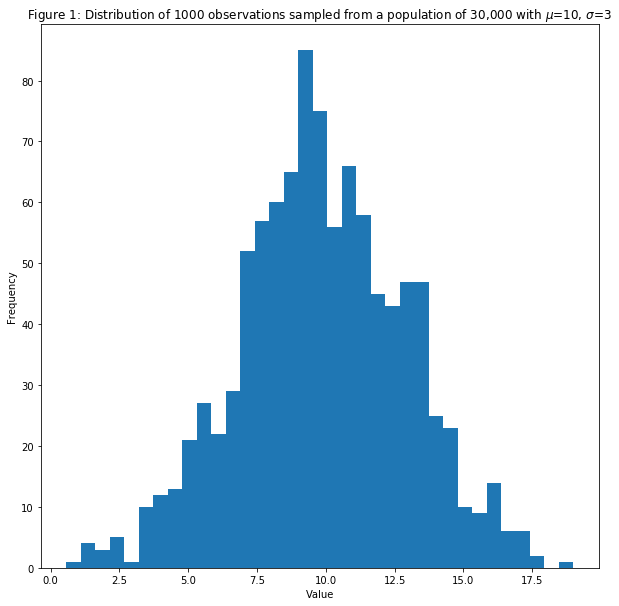

In [3]:
model=lambda mu, sig, t: np.random.normal(mu, sig, t)

#Form a population of 30,000 individuals, with average=10 and sigma=3
population = model(10, 3, 30000)

#Assume we are only able to observe 1,000 of these individuals, sample randomly amongst the 30000:
observation = population[np.random.randint(0,30000,1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

## Step 2: Which parameter to model

$\theta$ is made up of two values: $[\mu,\sigma]$. Let's assume  $\mu$ is a constant, $\mu = \mu_{obs}$.

We would like to find a distribution for $\sigma_{obs}$ using the 1000 observed samples. 

Those with a math background will say that ***there is a formula for computing the standard deviation*** $\sigma$ (actually, ***all of you need to know how to compute standard deviation from $n$ observations $d_i$ with mean $\mu$***):

$$\sigma=\sqrt{\frac{1}{n}\sum_i^n(d_i-\mu)^2}$$

Note however, we are not trying to find *a* value for $\sigma$, but rather, we are trying to compute a distribution of the possible values of $\sigma$.

#### b) Compute the standard deviation of the 30,000 samples, and then the standard deviation of the 1,000 observations in the cell below

Note that the standarde deviation of a non-gaussian distribution is ***nonsense***! Thankfully here, we have a distribution that ***is*** gaussian-distributed. 

In [3]:
mu=10
thesum = np.sum([(y-mu)**2 for y in population])
sigma_population = np.sqrt(thesum/len(population))
sigma_population

3.00607518695437

In [5]:
## or we can use the function directly 
np.std(population)

3.0060615129408266

In [8]:
# Standard deviation for 1000 observations
np.std(observation)

2.9312904140860727

## Step 3: Define the pdf for the prior and pdf for the likelihood

From the figure above, we can see that the data is **normally distributed**. The mean can be computed by taking the average of the values of the 1000 samples. By doing that, we get for example $\mu_{obs}=9.8$.

For the standard deviation $\sigma$ pdf, let's pick a simple one: the normal distribution!

\begin{equation} \sigma_{new} \sim N(\mu=\sigma_{current},\; \sigma_q=1) \end{equation}

Note that $\sigma_q$ is unrelated to $\sigma_{new}$ and $\sigma_{current}$. It simply specifies the standard deviation of the parameter space. It can be any value desired. It only affects convergence time of the algorithm.

We don't have any preferences values that $\sigma_{new}$ and $\sigma_{current}$ can take, but they should be positive! Why?

Standard deviation measures **dispersion**, which is a distance, and distances cannot be negative.

$\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$, and the square root of a number cannot be negative. Make sure to strictly enforce this in your prior.

Since likelihood $f$ should be proportional to the posterior, we choose $f$ to be the following pdf, for each data point $d_i$ in the data D:

\begin{equation} f(d_i\;|\; \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

#### c) Write a python function to evaluate $f$ above and plot f

<div style="display:none;">
import seaborn as sns

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
like = gaussian(x, 0., 1.)
ax.plot(x, like)
ax.set(xlabel='x', ylabel='f', title='Analytical likelihood');
sns.despine()
</div>

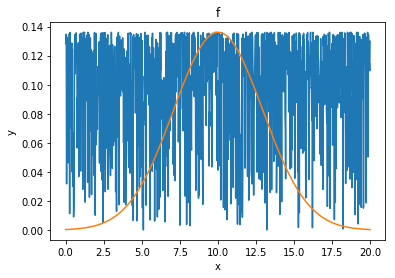

In [19]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/np.sqrt(2*np.pi*np.power(sig,2))
pdf_obs = gaussian(observation,np.mean(observation),np.std(observation))

ax = plt.subplot()
x = np.linspace(0, 20, 1000)
g = gaussian(x, np.mean(observation), np.std(observation))
f = gaussian(observation.tolist(), np.mean(observation), np.std(observation))
ax.plot(x, f)
ax.plot(x, g)
ax.set(xlabel='x', ylabel='y', title='f');

## Step 4: Define when we accept or reject $\sigma_{new}$: 
We accept $\sigma_{new}$ from $\sigma_{current}$ if and only if:

$\dfrac{\text{Likelihood}(D \;|\; \mu_{obs},\sigma_{new})\; * \; \text{prior}(\mu_{obs},\sigma_{new})}{\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{current})\;*\;\text{prior}(\mu_{obs},\sigma_{current})} \;\;>\;\; 1     \quad \quad \quad \quad \quad      (1)$

If this ratio is smaller or equal to 1, then we compare it to a uniformly generated random number in the closed set [0,1]. If the ratio is larger than the random number, we accept $\sigma_{new}$, otherwise we reject it.

*Note: Since we will be computing this ratio to decide which parameters should be accepted, make sure that the adopted likelihood is proportional to the posterior itself, $P(\sigma\;|\; D,\mu)$, which in our case is true.*


## Step 5: Acceptance condition derivation:

The **total** likelihood for a set of observations $D$ is: $\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) = \prod_i^n f(d_i\;|\;\mu_{obs},\sigma_{new}) $

In our case, we will **log** both the prior and the likelihood function. Why log? Simply because it helps with 
**numerical stability**, i.e. multiplying thousands of small values (probabilities, likelihoods, etc..) can cause an **underflow** in  system memory, and the **log** is a perfect solution (remember the problems we had with our previous notebook?) because it transforms multiplications to **additions** and small positive numbers into not-so-small negative numbers.

Therefore our acceptance condition from equation $(1)$ above becomes, after taking the **log** of equation (1):

Accept $\sigma_{new}$ if:

$$Log(\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new})) + Log(\text{prior}(\mu_{obs},\sigma_{new})) - (Log(\text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current})) + Log(prior(\mu_{obs},\sigma_{current})))\;>\;0$$

 $\quad$

 And that is equivalent to:
 
 $$\sum_i^nLog(f(d_i\;|\;\mu_{obs},\sigma_{new})) + Log(\text{prior}(\mu_{obs},\sigma_{new})) - \sum_i^nLog(f(d_i\;|\;\mu_{obs},\sigma_{current}))-Log(\text{prior}(\mu_{obs},\sigma_{current}))>0$$
 
 $\quad$
 
 
which is equivalent to: 
  
$$\sum_i^n -nLog(\sigma_{new}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{new}^2} + Log(prior(\mu_{obs},\sigma_{new})) \quad > \quad \sum_i^n -nLog(\sigma_{current}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{current}^2}+Log(prior(\mu_{obs},\sigma_{current})) \quad \quad  (2)$$

So let's write some code:

#### d) Please fill in the ellipses below for `prior` and `manual_log_likelihood`

Note that x are our **unknowns**: the parameters $\mu$ and $\sigma$ (in our case $\mu$ is fixed).

In [47]:
transition_model = lambda x: [x[0], np.random.normal(x[1], 0.5, (1,))]
transition_model([10,3])

[10, array([2.64597569])]

In [23]:
# The transition model defines how to move from sigma_current to sigma_new: we use numpy's 
# gaussian-distributed random number generator
transition_model = lambda x: [x[0], np.random.normal(x[1], 0.5, (1,))]

def prior(x):
    # the input is a 2-element list
    # x[0] = mu, x[1]=sigma (new or current)
    # returns 1 for all **valid** values of sigma. 
    if(x[1]<=0):
        return 0
    return 1

# Likelihood of the data given a sigma, whether new or current, according to our equation #2 above
def manual_log_likelihood(x, data):
    # x[0] = mu, x[1] = sigma 
    # data = observations
    return np.sum(-np.log(x[1] * np.sqrt(2*np.pi))-((data-x[0])**2)/(2*x[1]**2))

#Same as manual_log_likelihood(x, data), using scipy
def log_likelihood(x, data):
    # x[0] = mu, x[1] = sigma
    # data = observations
    return np.sum(np.log(scipy.stats.norm(x[0], x[1]).pdf(data)))

#### e) Please write your own Metropolis algorithm below

Note that `likelihood_computation(x,data)` is the **likelihood** that parameters x generated the data. That will the function `manual_log_likelihood` written above.

`transition_model(x)`: is a function that draws a sample from a symmetric distribution and returns it.

`param_init` is the starting sample. So you start your Metropolis program with `x = param_init`

`iterations` is the number of accepted to generated

`data` are the observations we wish to model

`acceptance_rule(x, x_new)` is a predicate that decides whether to accept or reject the new sample.

So, start with x equal to `param_init`, and with two lists, one are the accepted values, the other the rejected values.

Then for index i ranging in `range(iterations)`, set `x_new` equal to `transition_model(x)`, and `x_likely` to `likelihood_computation(x, data)`. Then evaluate a new candidate `x_new_likely` in the same way.

Then plug in equation (2) as input to your `acceptance_rule`. Equation (2) can simply be written as comparing `(x_likely + np.log(prior(x))` to `(x_new_likely + np.log(prior(x_new))`. If the new value `x_new` is accepted, replace `x` with `x_new` in order to start the next iteration, and add `x_new` to the accepted list. If the new value `x_new` is rejected, then just add it to the rejected list.

At the end of `iterations`, return the accepted list and the rejected list as numpy arrays (`np.array()`).

Simple, right?

Implemented the **metropolis_hastings** function

In [58]:
# Predicate whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we want a **log** likelihood, we want to exponentiate 
        # in order to compare to the random number. Make sure less
        # likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new - x)))

# Write a metropolis algorithm:
def metropolis_hastings(likelihood_computation, 
                        prior, 
                        transition_model, 
                        param_init, 
                        iterations, 
                        data, 
                        acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new=transition_model(x)
        x_likely=manual_log_likelihood(x,data)
        x_new_likely=manual_log_likelihood(x_new,data)
        if acceptance(x_likely + np.log(prior(x)),x_new_likely + np.log(prior(x_new))):
            x=x_new
            accepted.append(x)
        else: 
            rejected.append(x_new)
                                        
    return np.array(accepted), np.array(rejected)

## Step 6: Run the algorithm with initial parameters and collect `accepted` and `rejected` samples

Run your Metroplois algorithm with the following parameters:

- manual_log_likelihood
- prior
- transition_model
- [mu_obs,0.1]
- 50000
- observation
- acceptance

In [59]:
accepted, rejected = metropolis_hastings(manual_log_likelihood, 
                        prior, 
                        transition_model, 
                        [mu_obs,.1], 
                        50000, 
                        observation, 
                        acceptance)

In [60]:
len(accepted) ## Number of samples accepted

8203

In [74]:
len(rejected)# Number of samples rejected

41797

The algorithm accepted how many samples (which might be different on each new run)?

#### f) What are the last 10 samples for $\sigma$:

In [68]:
accepted

array([[10.01870953,  1.09375967],
       [10.01870953,  1.55867897],
       [10.01870953,  1.78879674],
       ...,
       [10.01870953,  3.02786916],
       [10.01870953,  2.85794693],
       [10.01870953,  2.90823227]])

In [69]:
accepted[-10:]

array([[10.01870953,  2.91648298],
       [10.01870953,  2.90994354],
       [10.01870953,  2.85548924],
       [10.01870953,  2.84238391],
       [10.01870953,  3.00127632],
       [10.01870953,  2.97385853],
       [10.01870953,  2.94818532],
       [10.01870953,  3.02786916],
       [10.01870953,  2.85794693],
       [10.01870953,  2.90823227]])

In [70]:
print(accepted.shape)

(8203, 2)


#### g) Plot accepted and rejected values:

(8203, 2)

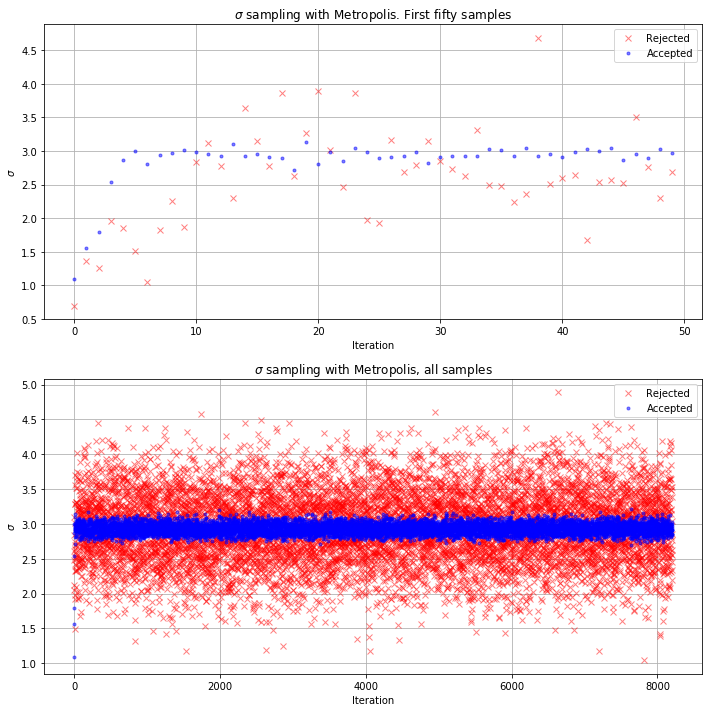

In [71]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("$\sigma$ sampling with Metropolis. First fifty samples")
ax.grid()
ax.legend()


ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("$\sigma$ sampling with Metropolis, all samples")
ax2.grid()
ax2.legend()


fig.tight_layout()
accepted.shape

#### h) So, starting from an initial σ of 0.1, the algorithm converges pretty quickly to which expected value?

Now, consider the initial 25% of the values of $\sigma$ to be "burn-in", so ***drop them***.

Visualize the trace of  $\sigma$ and the histogram of the trace.

C:\Users\Harika\Anaconda2\envs\theano3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


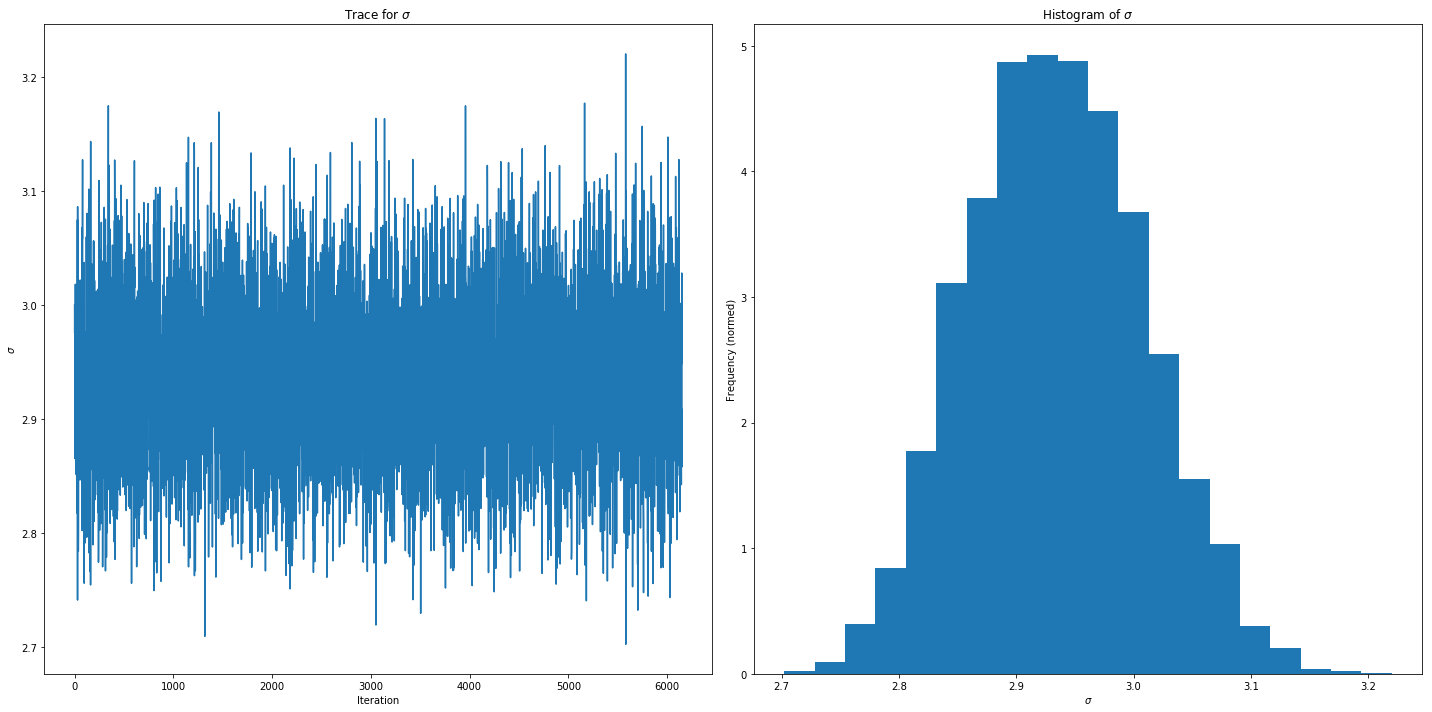

In [72]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")


The most likely value for $\sigma$ is around what value? A bit more or less than the original value of 3.0? The difference is due to observing only 3% f the original population (1,000 out of 30,000) 

## Predictions:

#### i) First, average out the last 75% of accepted samples of σ, and then generate 30,000 random individuals from a normal distribution with μ=9.8 and your value of σ. 

Then compare against the original data of 30,000 individuals.

10.01870952848041 2.9343375802690805


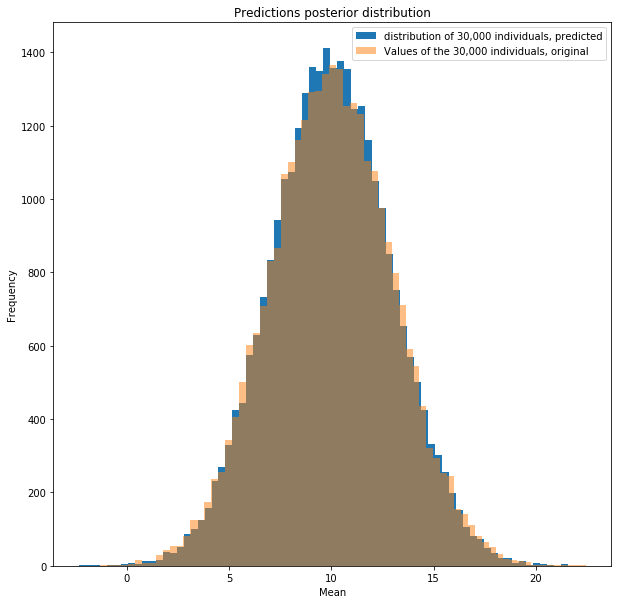

In [73]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="distribution of 30,000 individuals, predicted")
ax.hist( population,bins=70 ,alpha=0.5, label="Values of the 30,000 individuals, original")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Predictions posterior distribution")
ax.legend()

#### Is it a good fit? 

Your model generated, from a small 1,000 sample of 30,000 observations, a model of ***all 30,000 observations***!

## Conclusion

The great thing about probabilistic programming is that you only need to write down the model and then run it. The simplest MCMC algorithm, [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), is very simple. There is no need to compute evidence (denominator), or ensure constraining mathematical properties. Once you have a good model, it essentially **simulates** the data, so you can throw away all your data and use your model to predict new data. If your model is low dimensional, then you turned something complicated into something very easy. Well done! Your brain loves you! That's called **intelligence**!